In [1]:
import vaex
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
from scipy import interpolate
from os.path import join, abspath
import sys
from os import pardir, mkdir
from scipy.stats import norm

plt.style.use('seaborn-v0_8-whitegrid') # I personally prefer seaborn for the graph style, but you may choose whichever you want.
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern"]}
plt.rcParams.update(params)

In [2]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

from utils import load_spectral_types

In [3]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [5]:
name = "GUMS"
data_dir = join(root_data_dir, name)
data_dir

'/home2/s20321005/Thesis-Project/Data/GUMS'

In [6]:
# path to best-pars, created at 3.3. Best-pars.ipynb
files = glob(join(data_dir, "*.hdf5"))
files[:5]

['/home2/s20321005/Thesis-Project/Data/GUMS/gaia-330-340.hdf5',
 '/home2/s20321005/Thesis-Project/Data/GUMS/gaia-190-200.hdf5',
 '/home2/s20321005/Thesis-Project/Data/GUMS/gaia-060-070.hdf5',
 '/home2/s20321005/Thesis-Project/Data/GUMS/gaia-310-320.hdf5',
 '/home2/s20321005/Thesis-Project/Data/GUMS/gaia-180-190.hdf5']

In [37]:
gums_raw = vaex.open_many(files)
gums_raw = gums_raw.filter("barycentric_distance < 250")
gums_raw = gums_raw.extract()
gums_raw

#,ra,dec,barycentric_distance,pmra,pmdec,radial_velocity,mag_g,mag_bp,mag_rp,feh,alphafe,mass,population,logg,teff,spectral_type
0,335.0423406351893,-89.99999999999987,83.612,66.7089,50.11444,-12.412354,19.221436,20.362885,18.116106,0.11254041,0.012468732,0.552,1,4.757,3828.2473,K9V
1,334.62456439273825,-89.27086479306539,194.35336,13.223362,-1.6240374,1.6767337,19.403433,19.433006,19.347576,-0.07154667,0.01043097,0.9,1,8.49,10839.266,DBVII
2,330.76352726707285,-89.99999999999972,140.15117,18.354284,-39.722267,45.88338,19.141418,19.854698,18.28151,0.05160391,0.005072151,0.896,1,4.454,5675.4463,G2.5V
3,333.88067589833327,-89.99999999999974,126.98487,51.50644,-44.02756,-5.379475,16.723316,17.1123,16.147518,-0.04257653,0.021453567,1.006,1,4.515,5584.702,G3V
4,334.12408072513995,-89.99999999997604,5.021281,-3390.435,-863.4128,79.27912,18.5561,19.199005,17.743185,-0.6130799,0.26896033,0.958,2,4.092,6053.4087,F6.5IV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2,927,302",306.1623308752516,89.31425707176679,176.03947,53.578255,99.54518,-15.189127,14.439246,15.374528,13.440332,-0.13411474,0.048938565,0.795,1,nan,nan,
"2,927,303",306.16309846445023,89.31426479300954,176.03946,53.579597,99.54448,-11.489247,16.328732,17.264013,15.329818,-0.13411474,0.048938565,0.257,1,5.036,3723.917,M0.5V
"2,927,304",300.65901528507084,89.48466783726558,155.89896,48.82033,35.40954,21.854038,9.856618,10.131072,9.408596,-0.08244268,0.039174337,0.946,2,4.181,6109.4204,F6IV
"2,927,305",300.93090284401364,89.56943067225178,138.08827,47.412453,51.89462,17.276598,8.990281,9.204407,8.624119,-0.036068216,-0.0076244753,1.301,1,4.186,6531.3057,F5V


In [38]:
# transform ra,dec to galactic coordinates
ra = gums_raw['ra'].to_numpy()
dec = gums_raw['dec'].to_numpy()

from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
l, b = c.galactic.l.value, c.galactic.b.value
gums_raw['l'] = l*np.pi/180
gums_raw['b'] = b*np.pi/180
gums_raw["ra"] = gums_raw["ra"]*np.pi/180
gums_raw["dec"] = gums_raw["dec"]*np.pi/180
gums_raw

#,ra,dec,barycentric_distance,pmra,pmdec,radial_velocity,mag_g,mag_bp,mag_rp,feh,alphafe,mass,population,logg,teff,spectral_type,l,b
0,5.847591977672443,-1.5707963267948943,83.612,66.7089,50.11444,-12.412354,19.221436,20.362885,18.116106,0.11254041,0.012468732,0.552,1,4.757,3828.2473,K9V,5.287159505112386,-0.4734773249532965
1,5.840300406705063,-1.5580705167416773,194.35336,13.223362,-1.6240374,1.6767337,19.403433,19.433006,19.347576,-0.07154667,0.01043097,0.9,1,8.49,10839.266,DBVII,5.296054684735827,-0.48345711692825183
2,5.772912596320462,-1.5707963267948915,140.15117,18.354284,-39.722267,45.88338,19.141418,19.854698,18.28151,0.05160391,0.005072151,0.896,1,4.454,5675.4463,G2.5V,5.287159505112388,-0.47347732495329836
3,5.8273171032099915,-1.5707963267948921,126.98487,51.50644,-44.02756,-5.379475,16.723316,17.1123,16.147518,-0.04257653,0.021453567,1.006,1,4.515,5584.702,G3V,5.287159505112387,-0.4734773249532982
4,5.831565318853015,-1.5707963267944784,5.021281,-3390.435,-863.4128,79.27912,18.5561,19.199005,17.743185,-0.6130799,0.26896033,0.958,2,4.092,6053.4087,F6.5IV,5.287159505112678,-0.4734773249536209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2,927,302",5.343540719353433,1.55882785487496,176.03947,53.578255,99.54518,-15.189127,14.439246,15.374528,13.440332,-0.13411474,0.048938565,0.795,1,nan,nan,,2.1332458645213643,0.4687119197817775
"2,927,303",5.3435541163122515,1.5588279896360682,176.03946,53.579597,99.54448,-11.489247,16.328732,17.264013,15.329818,-0.13411474,0.048938565,0.257,1,5.036,3723.917,M0.5V,2.1332460749329822,0.468711826884397
"2,927,304",5.247489742528444,1.5618020838137576,155.89896,48.82033,35.40954,21.854038,9.856618,10.131072,9.408596,-0.08244268,0.039174337,0.946,2,4.181,6109.4204,F6IV,2.135958154192037,0.4707091693351079
"2,927,305",5.252235075627206,1.5632814743675914,138.08827,47.412453,51.89462,17.276598,8.990281,9.204407,8.624119,-0.036068216,-0.0076244753,1.301,1,4.186,6531.3057,F5V,2.1375492071972797,0.4711331607767661


In [39]:
gums_raw['z'] = gums_raw.evaluate('barycentric_distance * sin(b)')
gums_raw['r'] = gums_raw.evaluate('barycentric_distance * cos(b)')

gums_raw

#,ra,dec,barycentric_distance,pmra,pmdec,radial_velocity,mag_g,mag_bp,mag_rp,feh,alphafe,mass,population,logg,teff,spectral_type,l,b,z,r
0,5.847591977672443,-1.5707963267948943,83.612,66.7089,50.11444,-12.412354,19.221436,20.362885,18.116106,0.11254041,0.012468732,0.552,1,4.757,3828.2473,K9V,5.287159505112386,-0.4734773249532965,-38.12571840737445,74.41368192926113
1,5.840300406705063,-1.5580705167416773,194.35336,13.223362,-1.6240374,1.6767337,19.403433,19.433006,19.347576,-0.07154667,0.01043097,0.9,1,8.49,10839.266,DBVII,5.296054684735827,-0.48345711692825183,-90.3437721696584,172.07914619148738
2,5.772912596320462,-1.5707963267948915,140.15117,18.354284,-39.722267,45.88338,19.141418,19.854698,18.28151,0.05160391,0.005072151,0.896,1,4.454,5675.4463,G2.5V,5.287159505112388,-0.47347732495329836,-63.90666445275529,124.732868006167
3,5.8273171032099915,-1.5707963267948921,126.98487,51.50644,-44.02756,-5.379475,16.723316,17.1123,16.147518,-0.04257653,0.021453567,1.006,1,4.515,5584.702,G3V,5.287159505112387,-0.4734773249532982,-57.90304571842579,113.01501996072446
4,5.831565318853015,-1.5707963267944784,5.021281,-3390.435,-863.4128,79.27912,18.5561,19.199005,17.743185,-0.6130799,0.26896033,0.958,2,4.092,6053.4087,F6.5IV,5.287159505112678,-0.4734773249536209,-2.2896227530640925,4.4688799687357195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2,927,302",5.343540719353433,1.55882785487496,176.03947,53.578255,99.54518,-15.189127,14.439246,15.374528,13.440332,-0.13411474,0.048938565,0.795,1,nan,nan,,2.1332458645213643,0.4687119197817775,79.52363184534978,157.05377600010664
"2,927,303",5.3435541163122515,1.5588279896360682,176.03946,53.579597,99.54448,-11.489247,16.328732,17.264013,15.329818,-0.13411474,0.048938565,0.257,1,5.036,3723.917,M0.5V,2.1332460749329822,0.468711826884397,79.52361036249911,157.05376977449995
"2,927,304",5.247489742528444,1.5618020838137576,155.89896,48.82033,35.40954,21.854038,9.856618,10.131072,9.408596,-0.08244268,0.039174337,0.946,2,4.181,6109.4204,F6IV,2.135958154192037,0.4707091693351079,70.70305213380999,138.9444601055676
"2,927,305",5.252235075627206,1.5632814743675914,138.08827,47.412453,51.89462,17.276598,8.990281,9.204407,8.624119,-0.036068216,-0.0076244753,1.301,1,4.186,6531.3057,F5V,2.1375492071972797,0.4711331607767661,62.677753652260336,123.04417941216806


In [40]:
gums = gums_raw.filter("abs(z) < 200").filter("r < 150")
gums = gums.extract()
gums["M_G"] = gums["mag_g"] - 5 * np.log10(gums["barycentric_distance"]) + 5
gums

#,ra,dec,barycentric_distance,pmra,pmdec,radial_velocity,mag_g,mag_bp,mag_rp,feh,alphafe,mass,population,logg,teff,spectral_type,l,b,z,r,M_G
0,5.847591977672443,-1.5707963267948943,83.612,66.7089,50.11444,-12.412354,19.221436,20.362885,18.116106,0.11254041,0.012468732,0.552,1,4.757,3828.2473,K9V,5.287159505112386,-0.4734773249532965,-38.12571840737445,74.41368192926113,14.610092
1,5.772912596320462,-1.5707963267948915,140.15117,18.354284,-39.722267,45.88338,19.141418,19.854698,18.28151,0.05160391,0.005072151,0.896,1,4.454,5675.4463,G2.5V,5.287159505112388,-0.47347732495329836,-63.90666445275529,124.732868006167,13.408435
2,5.8273171032099915,-1.5707963267948921,126.98487,51.50644,-44.02756,-5.379475,16.723316,17.1123,16.147518,-0.04257653,0.021453567,1.006,1,4.515,5584.702,G3V,5.287159505112387,-0.4734773249532982,-57.90304571842579,113.01501996072446,11.204556
3,5.831565318853015,-1.5707963267944784,5.021281,-3390.435,-863.4128,79.27912,18.5561,19.199005,17.743185,-0.6130799,0.26896033,0.958,2,4.092,6053.4087,F6.5IV,5.287159505112678,-0.4734773249536209,-2.2896227530640925,4.4688799687357195,20.052029
4,5.843680675200906,-1.5563824276254117,166.21375,37.167286,20.467144,7.860309,14.172444,14.969129,13.251131,0.2810122,-0.014306631,0.594,1,4.72,3953.6663,K8V,5.2971984487768555,-0.4848087627414201,-77.46211550330851,147.05995283432352,8.06911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,327,243",5.3227728071214795,1.5547668647688142,73.78807,38.417828,50.192844,30.891592,10.856715,11.292931,10.238791,0.098279044,0.02843636,0.672,1,4.658,4920.3955,K1.5V,2.1289323330983208,0.4673871997753025,33.245602804447515,65.8741927362708,6.5167837
"1,327,244",5.282399454425923,1.5560105418750598,97.30824,61.020737,-32.075333,-17.297888,20.554504,20.845217,20.07421,-0.06657888,0.024732176,0.7,1,8.21,4742.4214,DBVII,2.1299756730660406,0.4684195981226664,43.93240280263574,86.82648271347051,15.613756
"1,327,245",5.247489742528444,1.5618020838137576,155.89896,48.82033,35.40954,21.854038,9.856618,10.131072,9.408596,-0.08244268,0.039174337,0.946,2,4.181,6109.4204,F6IV,2.135958154192037,0.4707091693351079,70.70305213380999,138.9444601055676,3.8924017
"1,327,246",5.252235075627206,1.5632814743675914,138.08827,47.412453,51.89462,17.276598,8.990281,9.204407,8.624119,-0.036068216,-0.0076244753,1.301,1,4.186,6531.3057,F5V,2.1375492071972797,0.4711331607767661,62.677753652260336,123.04417941216806,3.2894974


In [41]:
# transform proper motion to Galactic coordinates; https://arxiv.org/pdf/1306.2945.pdf
delta_G = 27.12825*np.pi/180
alpha_G = 192.8594813*np.pi/180
l_ngp = 122.93192*np.pi/180 

C1 = np.sin(delta_G)*np.cos(gums.dec) - np.cos(delta_G)*np.sin(gums.dec)*np.cos(gums.ra - alpha_G)
C2 = np.cos(delta_G)*np.sin(gums.ra - alpha_G)
cosb = np.sqrt(C1**2 + C2**2)

gums["pmlon"] = 1/cosb*(C1*gums.pmra+C2*gums.pmdec)
gums["pmlat"] = 1/cosb*(-1*C2*gums.pmra+C1*gums.pmdec)
gums

#,ra,dec,barycentric_distance,pmra,pmdec,radial_velocity,mag_g,mag_bp,mag_rp,feh,alphafe,mass,population,logg,teff,spectral_type,l,b,z,r,M_G,pmlon,pmlat
0,5.847591977672443,-1.5707963267948943,83.612,66.7089,50.11444,-12.412354,19.221436,20.362885,18.116106,0.11254041,0.012468732,0.552,1,4.757,3828.2473,K9V,5.287159505112386,-0.4734773249532965,-38.12571840737445,74.41368192926113,14.610092,-21.970798913426503,-80.49110872075164
1,5.772912596320462,-1.5707963267948915,140.15117,18.354284,-39.722267,45.88338,19.141418,19.854698,18.28151,0.05160391,0.005072151,0.896,1,4.454,5675.4463,G2.5V,5.287159505112388,-0.47347732495329836,-63.90666445275529,124.732868006167,13.408435,-40.2480883727991,17.170603996679077
2,5.8273171032099915,-1.5707963267948921,126.98487,51.50644,-44.02756,-5.379475,16.723316,17.1123,16.147518,-0.04257653,0.021453567,1.006,1,4.515,5584.702,G3V,5.287159505112387,-0.4734773249532982,-57.90304571842579,113.01501996072446,11.204556,-67.73479209988463,1.8268451808413657
3,5.831565318853015,-1.5707963267944784,5.021281,-3390.435,-863.4128,79.27912,18.5561,19.199005,17.743185,-0.6130799,0.26896033,0.958,2,4.092,6053.4087,F6.5IV,5.287159505112678,-0.4734773249536209,-2.2896227530640925,4.4688799687357195,20.052029,2104.429618886982,2794.978979469341
4,5.843680675200906,-1.5563824276254117,166.21375,37.167286,20.467144,7.860309,14.172444,14.969129,13.251131,0.2810122,-0.014306631,0.594,1,4.72,3953.6663,K8V,5.2971984487768555,-0.4848087627414201,-77.46211550330851,147.05995283432352,8.06911,-16.47851947915654,-39.09948238020873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,327,243",5.3227728071214795,1.5547668647688142,73.78807,38.417828,50.192844,30.891592,10.856715,11.292931,10.238791,0.098279044,0.02843636,0.672,1,4.658,4920.3955,K1.5V,2.1289323330983208,0.4673871997753025,33.245602804447515,65.8741927362708,6.5167837,61.08676626931133,-16.237551933229454
"1,327,244",5.282399454425923,1.5560105418750598,97.30824,61.020737,-32.075333,-17.297888,20.554504,20.845217,20.07421,-0.06657888,0.024732176,0.7,1,8.21,4742.4214,DBVII,2.1299756730660406,0.4684195981226664,43.93240280263574,86.82648271347051,15.613756,-9.02610953044054,-68.34388500468317
"1,327,245",5.247489742528444,1.5618020838137576,155.89896,48.82033,35.40954,21.854038,9.856618,10.131072,9.408596,-0.08244268,0.039174337,0.946,2,4.181,6109.4204,F6IV,2.135958154192037,0.4707091693351079,70.70305213380999,138.9444601055676,3.8924017,48.793669650261855,-35.44626887886905
"1,327,246",5.252235075627206,1.5632814743675914,138.08827,47.412453,51.89462,17.276598,8.990281,9.204407,8.624119,-0.036068216,-0.0076244753,1.301,1,4.186,6531.3057,F5V,2.1375492071972797,0.4711331607767661,62.677753652260336,123.04417941216806,3.2894974,64.14740334855021,-28.74200400752705


In [47]:
# calculate vertical velocities and their errors
gums['vb'] = 4.74*gums["pmlat"]*gums["barycentric_distance"]/1000
gums["vphi"] = 4.74*gums["pmlon"]*gums["barycentric_distance"]/1000

gums["w"] = gums["vb"]*np.cos(gums.b) + gums["radial_velocity"]*np.sin(gums.b)
gums["v_xy"] = gums["radial_velocity"]*np.cos(gums.b) - gums["vb"]*np.sin(gums.b)
gums["v"] = gums["vphi"]*np.sin(gums.l) + gums["v_xy"]*np.cos(gums.l)
gums["u"] = gums["vphi"]*np.cos(gums.l) - gums["v_xy"]*np.sin(gums.l)
gums

#,ra,dec,barycentric_distance,pmra,pmdec,radial_velocity,mag_g,mag_bp,mag_rp,feh,alphafe,mass,population,logg,teff,spectral_type,l,b,z,r,M_G,pmlon,pmlat,vb,vphi,w,v_xy,v,u
0,5.847591977672443,-1.5707963267948943,83.612,66.7089,50.11444,-12.412354,19.221436,20.362885,18.116106,0.11254041,0.012468732,0.552,1,4.757,3828.2473,K9V,5.287159505112386,-0.4734773249532965,-38.12571840737445,74.41368192926113,14.610092,-21.970798913426503,-80.49110872075164,-31.900306854091067,-8.707486308821851,-22.73105974640351,-25.592870953883583,-6.60502277687071,-26.21429067507792
1,5.772912596320462,-1.5707963267948915,140.15117,18.354284,-39.722267,45.88338,19.141418,19.854698,18.28151,0.05160391,0.005072151,0.896,1,4.454,5675.4463,G2.5V,5.287159505112388,-0.47347732495329836,-63.90666445275529,124.732868006167,13.408435,-40.2480883727991,17.170603996679077,11.406716240598774,-26.737470818373968,-10.770237650815776,46.03693949672859,47.46883903624173,24.103971966052015
2,5.8273171032099915,-1.5707963267948921,126.98487,51.50644,-44.02756,-5.379475,16.723316,17.1123,16.147518,-0.04257653,0.021453567,1.006,1,4.515,5584.702,G3V,5.287159505112387,-0.4734773249532982,-57.90304571842579,113.01501996072446,11.204556,-67.73479209988463,1.8268451808413657,1.0995932554540222,-40.77013275876554,3.431578456661821,-4.286271941294539,31.888870335777256,-25.761906005380915
3,5.831565318853015,-1.5707963267944784,5.021281,-3390.435,-863.4128,79.27912,18.5561,19.199005,17.743185,-0.6130799,0.26896033,0.958,2,4.092,6053.4087,F6.5IV,5.287159505112678,-0.4734773249536209,-2.2896227530640925,4.4688799687357195,20.052029,2104.429618886982,2794.978979469341,66.52293365908181,50.08725752706905,23.0546211013151,100.89085309516918,12.809435006614486,111.90896291032843
4,5.843680675200906,-1.5563824276254117,166.21375,37.167286,20.467144,7.860309,14.172444,14.969129,13.251131,0.2810122,-0.014306631,0.594,1,4.72,3953.6663,K8V,5.2971984487768555,-0.4848087627414201,-77.46211550330851,147.05995283432352,8.06911,-16.47851947915654,-39.09948238020873,-30.804650429164813,-12.982653509565218,-30.918060409637242,-7.401654415993237,6.739147684135978,-13.338578212636566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,327,243",5.3227728071214795,1.5547668647688142,73.78807,38.417828,50.192844,30.891592,10.856715,11.292931,10.238791,0.098279044,0.02843636,0.672,1,4.658,4920.3955,K1.5V,2.1289323330983208,0.4673871997753025,33.245602804447515,65.8741927362708,6.5167837,61.08676626931133,-16.237551933229454,-5.679172364770294,21.3654297320456,8.848296174985109,30.13720477141697,2.1622481786816596,-36.87895581335084
"1,327,244",5.282399454425923,1.5560105418750598,97.30824,61.020737,-32.075333,-17.297888,20.554504,20.845217,20.07421,-0.06657888,0.024732176,0.7,1,8.21,4742.4214,DBVII,2.1299756730660406,0.4684195981226664,43.93240280263574,86.82648271347051,15.613756,-9.02610953044054,-68.34388500468317,-31.523006706416904,-4.163212425536441,-35.9370333990477,-1.2027072392757532,-2.8910916205040382,3.228069337142351
"1,327,245",5.247489742528444,1.5618020838137576,155.89896,48.82033,35.40954,21.854038,9.856618,10.131072,9.408596,-0.08244268,0.039174337,0.946,2,4.181,6109.4204,F6IV,2.135958154192037,0.4707091693351079,70.70305213380999,138.9444601055676,3.8924017,48.793669650261855,-35.44626887886905,-26.193412170561725,36.05662149748708,-13.433587736368363,31.35653917442348,13.656814438487647,-45.79087160344207
"1,327,246",5.252235075627206,1.5632814743675914,138.08827,47.412453,51.89462,17.276598,8.990281,9.204407,8.624119,-0.036068216,-0.0076244753,1.301,1,4.186,6531.3057,F5V,2.1375492071972797,0.4711331607767661,62.677753652260336,123.04417941216806,3.2894974,64.14740334855021,-28.74200400752705,-18.812745595511412,41.98693937600504,-8.921398419068584,23.933426096939318,22.572482620403882,-42.73400275253353


In [63]:
gums["u_LSR"] = gums["u"]# - 11.1
gums["v_LSR"] = gums["v"]# - 12.4
gums["w_LSR"] = gums["w"] + 7.25

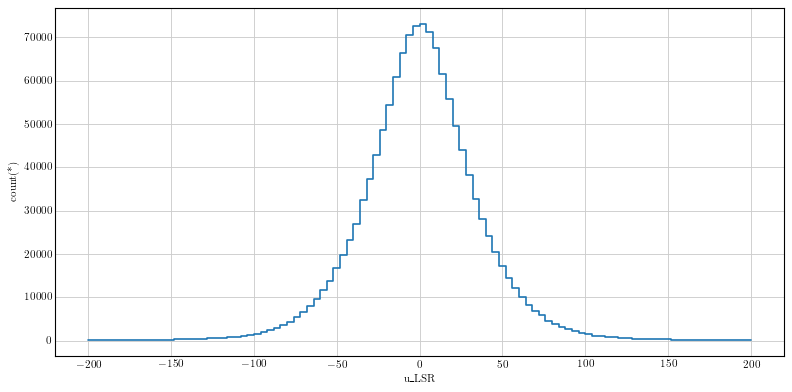

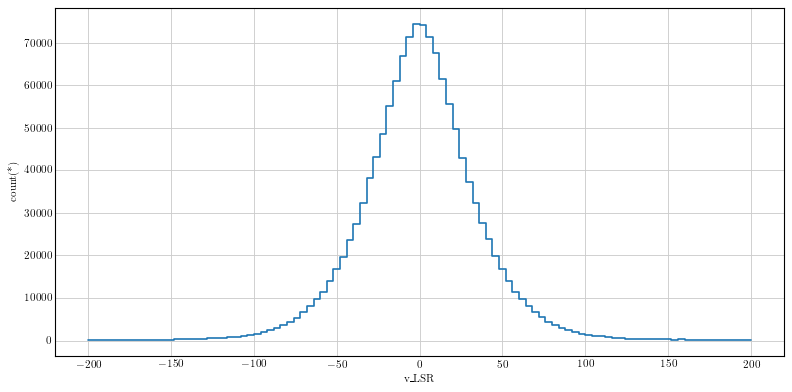

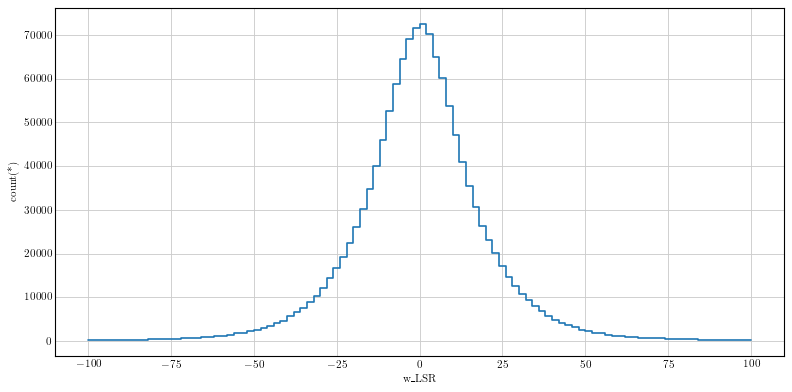

In [64]:
gums.viz.histogram("u_LSR", shape=100, limits=[-200, 200], figsize=(10, 5))
gums.viz.histogram("v_LSR", shape=100, limits=[-200, 200], figsize=(10, 5))
gums.viz.histogram("w_LSR", shape=100, limits=[-100, 100], figsize=(10, 5))

In [65]:
from scipy.stats import norm

gums["f_D"] = (norm.pdf(gums["u_LSR"].to_numpy(), loc=0, scale=35)*
                norm.pdf(gums["v_LSR"].to_numpy(), loc=-15, scale=20)*
                norm.pdf(gums["w_LSR"].to_numpy(), loc=0, scale=16))
gums["f_TD"] = (norm.pdf(gums["u_LSR"].to_numpy(), loc=0, scale=67)*
                norm.pdf(gums["v_LSR"].to_numpy(), loc=-46, scale=38)*
                norm.pdf(gums["w_LSR"].to_numpy(), loc=0, scale=35))
gums["f_H"] = (norm.pdf(gums["u_LSR"].to_numpy(), loc=0, scale=160)*
                norm.pdf(gums["v_LSR"].to_numpy(), loc=-220, scale=90)*
                norm.pdf(gums["w_LSR"].to_numpy(), loc=0, scale=90))
gums

#,ra,dec,barycentric_distance,pmra,pmdec,radial_velocity,mag_g,mag_bp,mag_rp,feh,alphafe,mass,population,logg,teff,spectral_type,l,b,z,r,M_G,pmlon,pmlat,vb,vphi,w,v_xy,v,u,u_LSR,v_LSR,w_LSR,f_D,f_TD,f_H
0,5.847591977672443,-1.5707963267948943,83.612,66.7089,50.11444,-12.412354,19.221436,20.362885,18.116106,0.11254041,0.012468732,0.552,1,4.757,3828.2473,K9V,5.287159505112386,-0.4734773249532965,-38.12571840737445,74.41368192926113,14.610092,-21.970798913426503,-80.49110872075164,-31.900306854091067,-8.707486308821851,-22.73105974640351,-25.592870953883583,-6.60502277687071,-26.21429067507792,-26.21429067507792,-6.60502277687071,-15.48105974640351,2.455557488748066e-06,3.497003004128416e-07,2.8647748810125506e-09
1,5.772912596320462,-1.5707963267948915,140.15117,18.354284,-39.722267,45.88338,19.141418,19.854698,18.28151,0.05160391,0.005072151,0.896,1,4.454,5675.4463,G2.5V,5.287159505112388,-0.47347732495329836,-63.90666445275529,124.732868006167,13.408435,-40.2480883727991,17.170603996679077,11.406716240598774,-26.737470818373968,-10.770237650815776,46.03693949672859,47.46883903624173,24.103971966052015,24.103971966052015,47.46883903624173,-3.520237650815776,3.323121497047419e-08,3.226470738652992e-08,5.848037289781763e-10
2,5.8273171032099915,-1.5707963267948921,126.98487,51.50644,-44.02756,-5.379475,16.723316,17.1123,16.147518,-0.04257653,0.021453567,1.006,1,4.515,5584.702,G3V,5.287159505112387,-0.4734773249532982,-57.90304571842579,113.01501996072446,11.204556,-67.73479209988463,1.8268451808413657,1.0995932554540222,-40.77013275876554,3.431578456661821,-4.286271941294539,31.888870335777256,-25.761906005380915,-25.761906005380915,31.888870335777256,10.681578456661821,2.2159278932227859e-07,7.729903492467035e-08,9.561010202269157e-10
3,5.831565318853015,-1.5707963267944784,5.021281,-3390.435,-863.4128,79.27912,18.5561,19.199005,17.743185,-0.6130799,0.26896033,0.958,2,4.092,6053.4087,F6.5IV,5.287159505112678,-0.4734773249536209,-2.2896227530640925,4.4688799687357195,20.052029,2104.429618886982,2794.978979469341,66.52293365908181,50.08725752706905,23.0546211013151,100.89085309516918,12.809435006614486,111.90896291032843,111.90896291032843,12.809435006614486,30.3046211013151,2.1612868765956487e-09,3.665306431063734e-08,1.2772027054932098e-09
4,5.843680675200906,-1.5563824276254117,166.21375,37.167286,20.467144,7.860309,14.172444,14.969129,13.251131,0.2810122,-0.014306631,0.594,1,4.72,3953.6663,K8V,5.2971984487768555,-0.4848087627414201,-77.46211550330851,147.05995283432352,8.06911,-16.47851947915654,-39.09948238020873,-30.804650429164813,-12.982653509565218,-30.918060409637242,-7.401654415993237,6.739147684135978,-13.338578212636566,-13.338578212636566,6.739147684135978,-23.668060409637242,9.778220295155898e-07,2.1214454250785123e-07,1.9740888120698574e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,327,243",5.3227728071214795,1.5547668647688142,73.78807,38.417828,50.192844,30.891592,10.856715,11.292931,10.238791,0.098279044,0.02843636,0.672,1,4.658,4920.3955,K1.5V,2.1289323330983208,0.4673871997753025,33.245602804447515,65.8741927362708,6.5167837,61.08676626931133,-16.237551933229454,-5.679172364770294,21.3654297320456,8.848296174985109,30.13720477141697,2.1622481786816596,-36.87895581335084,-36.87895581335084,2.1622481786816596,16.09829617498511,1.3573843876866067e-06,2.467490080903405e-07,2.2309457098911118e-09
"1,327,244",5.282399454425923,1.5560105418750598,97.30824,61.020737,-32.075333,-17.297888,20.554504,20.845217,20.07421,-0.06657888,0.024732176,0.7,1,8.21,4742.4214,DBVII,2.1299756730660406,0.4684195981226664,43.93240280263574,86.82648271347051,15.613756,-9.02610953044054,-68.34388500468317,-31.523006706416904,-4.163212425536441,-35.9370333990477,-1.2027072392757532,-2.8910916205040382,3.228069337142351,3.228069337142351,-2.8910916205040382,-28.6870333990477,9.419287952930656e-07,2.6727651881812733e-07,2.5370643185611166

In [66]:
gums["fTD_fD"] = gums["f_TD"]/gums["f_D"]
gums["fTD_fH"] = gums["f_TD"]/gums["f_H"]
gums

#,ra,dec,barycentric_distance,pmra,pmdec,radial_velocity,mag_g,mag_bp,mag_rp,feh,alphafe,mass,population,logg,teff,spectral_type,l,b,z,r,M_G,pmlon,pmlat,vb,vphi,w,v_xy,v,u,u_LSR,v_LSR,w_LSR,f_D,f_TD,f_H,fTD_fD,fTD_fH
0,5.847591977672443,-1.5707963267948943,83.612,66.7089,50.11444,-12.412354,19.221436,20.362885,18.116106,0.11254041,0.012468732,0.552,1,4.757,3828.2473,K9V,5.287159505112386,-0.4734773249532965,-38.12571840737445,74.41368192926113,14.610092,-21.970798913426503,-80.49110872075164,-31.900306854091067,-8.707486308821851,-22.73105974640351,-25.592870953883583,-6.60502277687071,-26.21429067507792,-26.21429067507792,-6.60502277687071,-15.48105974640351,2.455557488748066e-06,3.497003004128416e-07,2.8647748810125506e-09,0.14241177492901289,122.06903332286987
1,5.772912596320462,-1.5707963267948915,140.15117,18.354284,-39.722267,45.88338,19.141418,19.854698,18.28151,0.05160391,0.005072151,0.896,1,4.454,5675.4463,G2.5V,5.287159505112388,-0.47347732495329836,-63.90666445275529,124.732868006167,13.408435,-40.2480883727991,17.170603996679077,11.406716240598774,-26.737470818373968,-10.770237650815776,46.03693949672859,47.46883903624173,24.103971966052015,24.103971966052015,47.46883903624173,-3.520237650815776,3.323121497047419e-08,3.226470738652992e-08,5.848037289781763e-10,0.9709156711602928,55.17185644986538
2,5.8273171032099915,-1.5707963267948921,126.98487,51.50644,-44.02756,-5.379475,16.723316,17.1123,16.147518,-0.04257653,0.021453567,1.006,1,4.515,5584.702,G3V,5.287159505112387,-0.4734773249532982,-57.90304571842579,113.01501996072446,11.204556,-67.73479209988463,1.8268451808413657,1.0995932554540222,-40.77013275876554,3.431578456661821,-4.286271941294539,31.888870335777256,-25.761906005380915,-25.761906005380915,31.888870335777256,10.681578456661821,2.2159278932227859e-07,7.729903492467035e-08,9.561010202269157e-10,0.34883371052407625,80.84818788952303
3,5.831565318853015,-1.5707963267944784,5.021281,-3390.435,-863.4128,79.27912,18.5561,19.199005,17.743185,-0.6130799,0.26896033,0.958,2,4.092,6053.4087,F6.5IV,5.287159505112678,-0.4734773249536209,-2.2896227530640925,4.4688799687357195,20.052029,2104.429618886982,2794.978979469341,66.52293365908181,50.08725752706905,23.0546211013151,100.89085309516918,12.809435006614486,111.90896291032843,111.90896291032843,12.809435006614486,30.3046211013151,2.1612868765956487e-09,3.665306431063734e-08,1.2772027054932098e-09,16.958907541404876,28.69792254040305
4,5.843680675200906,-1.5563824276254117,166.21375,37.167286,20.467144,7.860309,14.172444,14.969129,13.251131,0.2810122,-0.014306631,0.594,1,4.72,3953.6663,K8V,5.2971984487768555,-0.4848087627414201,-77.46211550330851,147.05995283432352,8.06911,-16.47851947915654,-39.09948238020873,-30.804650429164813,-12.982653509565218,-30.918060409637242,-7.401654415993237,6.739147684135978,-13.338578212636566,-13.338578212636566,6.739147684135978,-23.668060409637242,9.778220295155898e-07,2.1214454250785123e-07,1.9740888120698574e-09,0.21695619049710613,107.46453817618011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,327,243",5.3227728071214795,1.5547668647688142,73.78807,38.417828,50.192844,30.891592,10.856715,11.292931,10.238791,0.098279044,0.02843636,0.672,1,4.658,4920.3955,K1.5V,2.1289323330983208,0.4673871997753025,33.245602804447515,65.8741927362708,6.5167837,61.08676626931133,-16.237551933229454,-5.679172364770294,21.3654297320456,8.848296174985109,30.13720477141697,2.1622481786816596,-36.87895581335084,-36.87895581335084,2.1622481786816596,16.09829617498511,1.3573843876866067e-06,2.467490080903405e-07,2.2309457098911118e-09,0.18178270674740515,110.60287437581073
"1,327,244",5.282399454425923,1.5560105418750598,97.30824,61.020737,-32.075333,-17.297888,20.554504,20.845217,20.07421,-0.06657888,0.024732176,0.7,1,8.21,4742.4214,DBVII,2.1299756730660406,0.4684195981226664,43.93240280263574,86.82648271347051,15.613756,-9.02610953044054,-6

In [85]:
gums["TD_D"] = gums["fTD_fD"]*0.09/0.85
gums

#,ra,dec,barycentric_distance,pmra,pmdec,radial_velocity,mag_g,mag_bp,mag_rp,feh,alphafe,mass,population,logg,teff,spectral_type,l,b,z,r,M_G,pmlon,pmlat,vb,vphi,w,v_xy,v,u,u_LSR,v_LSR,w_LSR,f_D,f_TD,f_H,fTD_fD,fTD_fH,TD_D
0,5.847591977672443,-1.5707963267948943,83.612,66.7089,50.11444,-12.412354,19.221436,20.362885,18.116106,0.11254041,0.012468732,0.552,1,4.757,3828.2473,K9V,5.287159505112386,-0.4734773249532965,-38.12571840737445,74.41368192926113,14.610092,-21.970798913426503,-80.49110872075164,-31.900306854091067,-8.707486308821851,-22.73105974640351,-25.592870953883583,-6.60502277687071,-26.21429067507792,-26.21429067507792,-6.60502277687071,-15.48105974640351,2.455557488748066e-06,3.497003004128416e-07,2.8647748810125506e-09,0.14241177492901289,122.06903332286987,0.015078893816013128
1,5.772912596320462,-1.5707963267948915,140.15117,18.354284,-39.722267,45.88338,19.141418,19.854698,18.28151,0.05160391,0.005072151,0.896,1,4.454,5675.4463,G2.5V,5.287159505112388,-0.47347732495329836,-63.90666445275529,124.732868006167,13.408435,-40.2480883727991,17.170603996679077,11.406716240598774,-26.737470818373968,-10.770237650815776,46.03693949672859,47.46883903624173,24.103971966052015,24.103971966052015,47.46883903624173,-3.520237650815776,3.323121497047419e-08,3.226470738652992e-08,5.848037289781763e-10,0.9709156711602928,55.17185644986538,0.10280283576991335
2,5.8273171032099915,-1.5707963267948921,126.98487,51.50644,-44.02756,-5.379475,16.723316,17.1123,16.147518,-0.04257653,0.021453567,1.006,1,4.515,5584.702,G3V,5.287159505112387,-0.4734773249532982,-57.90304571842579,113.01501996072446,11.204556,-67.73479209988463,1.8268451808413657,1.0995932554540222,-40.77013275876554,3.431578456661821,-4.286271941294539,31.888870335777256,-25.761906005380915,-25.761906005380915,31.888870335777256,10.681578456661821,2.2159278932227859e-07,7.729903492467035e-08,9.561010202269157e-10,0.34883371052407625,80.84818788952303,0.036935334055490425
3,5.831565318853015,-1.5707963267944784,5.021281,-3390.435,-863.4128,79.27912,18.5561,19.199005,17.743185,-0.6130799,0.26896033,0.958,2,4.092,6053.4087,F6.5IV,5.287159505112678,-0.4734773249536209,-2.2896227530640925,4.4688799687357195,20.052029,2104.429618886982,2794.978979469341,66.52293365908181,50.08725752706905,23.0546211013151,100.89085309516918,12.809435006614486,111.90896291032843,111.90896291032843,12.809435006614486,30.3046211013151,2.1612868765956487e-09,3.665306431063734e-08,1.2772027054932098e-09,16.958907541404876,28.69792254040305,1.7956490337958104
4,5.843680675200906,-1.5563824276254117,166.21375,37.167286,20.467144,7.860309,14.172444,14.969129,13.251131,0.2810122,-0.014306631,0.594,1,4.72,3953.6663,K8V,5.2971984487768555,-0.4848087627414201,-77.46211550330851,147.05995283432352,8.06911,-16.47851947915654,-39.09948238020873,-30.804650429164813,-12.982653509565218,-30.918060409637242,-7.401654415993237,6.739147684135978,-13.338578212636566,-13.338578212636566,6.739147684135978,-23.668060409637242,9.778220295155898e-07,2.1214454250785123e-07,1.9740888120698574e-09,0.21695619049710613,107.46453817618011,0.022971831934987707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,327,243",5.3227728071214795,1.5547668647688142,73.78807,38.417828,50.192844,30.891592,10.856715,11.292931,10.238791,0.098279044,0.02843636,0.672,1,4.658,4920.3955,K1.5V,2.1289323330983208,0.4673871997753025,33.245602804447515,65.8741927362708,6.5167837,61.08676626931133,-16.237551933229454,-5.679172364770294,21.3654297320456,8.848296174985109,30.13720477141697,2.1622481786816596,-36.87895581335084,-36.87895581335084,2.1622481786816596,16.09829617498511,1.3573843876866067e-06,2.467490080903405e-07,2.2309457098911118e-09,0.18178270674740515,110.60287437581073,0.019247580714431133
"1,327,244",5.282399454425923,1.5560105418750598,97.30824,61.020737,-32.075333,-17.297888,20.554504,20.845217,20.07421,-0.06657888,0.024732176

/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages/vaex/arrow/numpy_dispatch.py:72: RuntimeWarning: divide by zero encountered in divide
  result_data = op['op'](a_data, b_data)


Text(-3, 4, 'Piringan tebal')

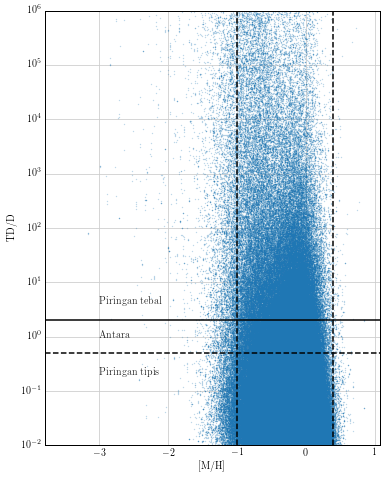

In [86]:
plt.figure(figsize=(6, 8))
gums.viz.scatter("feh", "TD_D", length_check=False, s=0.1, alpha=0.4)
plt.yscale("log")
plt.ylim(1e-2, 1e6)
plt.axvline(0.4, c="k", ls="--")
plt.axvline(-1, c="k", ls="--")
# plt.axvline(-0.3, c="r")
plt.axhline(2, c="k")
plt.axhline(0.5, c="k", ls="--")
plt.xlabel("[M/H]")
plt.ylabel("TD/D")
plt.text(-3, 2E-1, "Piringan tipis")
plt.text(-3, 0.9, "Antara")
plt.text(-3, 4, "Piringan tebal")

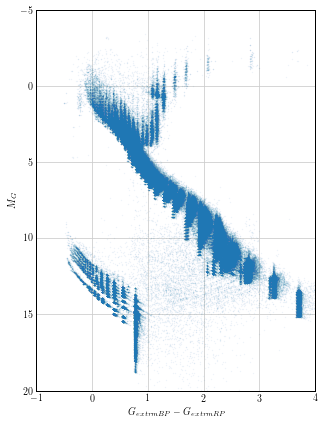

In [87]:
plt.figure(figsize=(5, 7))
gums.viz.scatter("mag_bp - mag_rp", "M_G", length_check=False, s=0.1, alpha=0.1)
plt.xlabel("$G_{\textrm{BP}} - G_{\textrm{RP}}$")
plt.ylabel("$M_G$")
# reverse y-axis
plt.xlim(-1,4)
plt.ylim(-5, 20)
plt.gca().invert_yaxis()
plt.show()

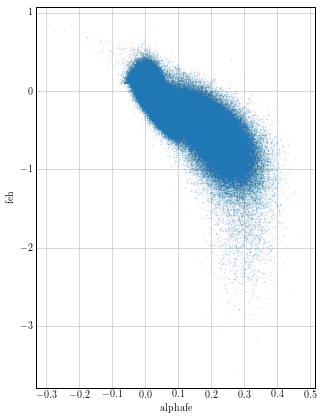

In [88]:
plt.figure(figsize=(5, 7))
gums.viz.scatter("alphafe", "feh", length_check=False, s=0.1, alpha=0.1)
# reverse y-axis
# plt.xlim(-1,4)
# plt.ylim(-5, 20)
plt.show()

In [89]:
gums_thin = gums.filter("population == 1")
gums_thin = gums_thin.extract()
gums_thick = gums.filter("population == 2")
gums_thick = gums_thick.extract()
gums_halo = gums.filter("population == 3")
gums_halo = gums_halo.extract()

In [90]:
len(gums_thin), len(gums_thick), len(gums_halo)

(1085610, 234345, 6856)

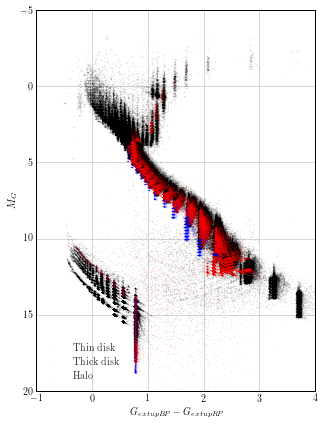

In [75]:
plt.figure(figsize=(5, 7))
gums_thin.viz.scatter("mag_bp - mag_rp", "M_G", length_check=False, s=0.1, alpha=0.1, c="k")
gums_thick.viz.scatter("mag_bp - mag_rp", "M_G", length_check=False, s=0.1, alpha=0.1, c="r")
gums_halo.viz.scatter("mag_bp - mag_rp", "M_G", length_check=False, s=0.1, alpha=0.1, c="b")
plt.xlabel("$G_{\textup{BP}} - G_{\textup{RP}}$")
plt.ylabel("$M_G$")
# reverse y-axis
plt.xlim(-1,4)
plt.ylim(-5, 20)
plt.legend(["Thin disk", "Thick disk", "Halo"])
plt.gca().invert_yaxis()
plt.show()

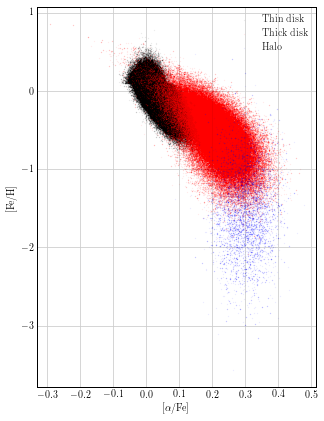

In [76]:
plt.figure(figsize=(5, 7))
gums_thin.viz.scatter("alphafe", "feh", length_check=False, s=0.1, alpha=0.1, c="k")
gums_thick.viz.scatter("alphafe", "feh", length_check=False, s=0.1, alpha=0.1, c="r")
gums_halo.viz.scatter("alphafe", "feh", length_check=False, s=0.1, alpha=0.1, c="b")
plt.xlabel(r"[$\alpha$/Fe]")
plt.ylabel("[Fe/H]")
plt.legend(["Thin disk", "Thick disk", "Halo"])
# reverse y-axis
# plt.xlim(-1,4)
# plt.ylim(-5, 20)
plt.show()

/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages/vaex/arrow/numpy_dispatch.py:72: RuntimeWarning: divide by zero encountered in divide
  result_data = op['op'](a_data, b_data)


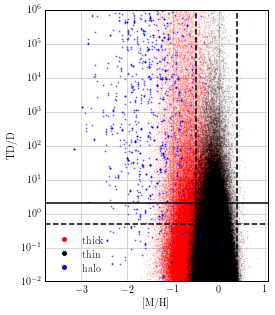

In [98]:
from matplotlib.lines import Line2D

plt.figure(figsize=(4, 5))
gums_thick.viz.scatter("feh", "fTD_fD*0.09/0.85", length_check=False, s=0.1, alpha=0.1, c="r")
gums_thin.viz.scatter("feh", "TD_D", length_check=False, s=0.1, alpha=0.1, c="k")
gums_halo.viz.scatter("feh", "TD_D", length_check=False, s=0.7, alpha=0.5, c="b")
plt.yscale("log")
plt.ylim(1e-2, 1e6)
plt.axvline(0.4, c="k", ls="--")
plt.axvline(-0.5, c="k", ls="--")
# plt.axvline(-0.3, c="r")
plt.axhline(2, c="k")
plt.axhline(0.5, c="k", ls="--")
plt.xlabel("[M/H]")
plt.ylabel("TD/D")
plt.text(-3, 2E-1, "Piringan tipis")
plt.text(-3, 0.9, "Antara")
plt.text(-3, 4, "Piringan tebal")
handles = [Line2D([0], [0], marker='o', color='w', label='thick', markerfacecolor='r'), 
           Line2D([0], [0], marker='o', color='w', label='thin', markerfacecolor='k'),
           Line2D([0], [0], marker='o', color='w', label='halo', markerfacecolor='b')]
plt.legend(loc="best", handles=handles)
plt.savefig("TD_D.pdf", format="pdf", bbox_inches="tight")
plt.show()

/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages/vaex/arrow/numpy_dispatch.py:72: RuntimeWarning: divide by zero encountered in divide
  result_data = op['op'](a_data, b_data)


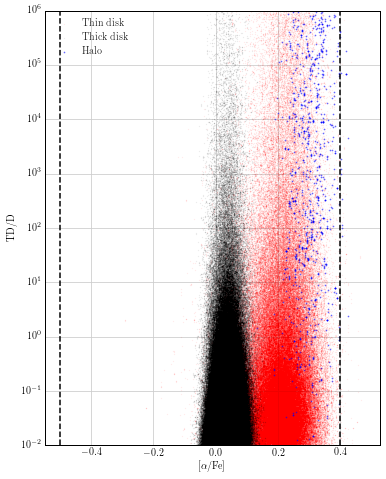

In [93]:
plt.figure(figsize=(6, 8))
gums_thick.viz.scatter("alphafe", "TD_D", length_check=False, s=0.1, alpha=0.1, c="r")
gums_thin.viz.scatter("alphafe", "TD_D", length_check=False, s=0.1, alpha=0.1, c="k")
gums_halo.viz.scatter("alphafe", "TD_D", length_check=False, s=0.5, alpha=0.5, c="b")
plt.yscale("log")
plt.ylim(1e-2, 1e6)
plt.axvline(0.4, c="k", ls="--")
plt.axvline(-0.5, c="k", ls="--")
# plt.axvline(-0.3, c="r")
# plt.axhline(2, c="k")
# plt.axhline(-0.5, c="k", ls="--")
plt.xlabel(r"[$\alpha$/Fe]")
plt.ylabel("TD/D")
# plt.text(-3, 2E-1, "Piringan tipis")
# plt.text(-3, 0.9, "Antara")
# plt.text(-3, 4, "Piringan tebal")
plt.legend(["Thin disk", "Thick disk", "Halo"])
plt.show()

In [97]:
gums.export(join(data_dir, "gums-filtered.hdf5"), progress=True)

export(hdf5) [#######################################-] 98.53% estimated time:     0.72s =  0.0m =  0.0h  

/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages/vaex/arrow/numpy_dispatch.py:72: RuntimeWarning: divide by zero encountered in divide
  result_data = op['op'](a_data, b_data)


export(hdf5) [########################################] 100.00% elapsed time  :    48.95s =  0.8m =  0.0h
 